# asd_a2_processing

@author: David Clemens-Sewall

Notebook for applying MOSAiC-style automated processing to ASD level a1 files to flag data.

This includes the following automated checks for which the entire scan is flagged:
  1. Variability in the incident at 600 nm. Greater than 15% change averaged between the preceeding and following measurement. (Flag 2)
  2. Offset between 1000 nm to 1001 nm (VNIR to SWIR sensors) is greater than 50% of albedo at 1000 nm. (Flag 3)
  3. Slope of albedos between 400 and 450 nm is negative (Flag 4)

Clean albedo data:

  4. Parabolic correction from 750 to 1000 nm for temperature-offset between VNIR and SWIR (procedure from ASD manual).
  5. Flag wavelengths where rolling standard deviation over 20 nm is greater than 0.02. (Flag 5)
  6. Smooth wavelengths from 1200 nm to 1799 nm with a rolling mean of 15 nm window, and from 1800 nm - 2500 nm 30 nm window.
  
Non-physical parts of scans are removed:

  7. Flag albedo values greater than 1 or less than 0 (Flag 6)

In [1]:
# Imports
import os
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [31]:
# Data paths
a1_dir = os.path.join('..', '..', 'export', 'final-upload-data', 'spectral_albedo_2024', 'a1')
a2_dir = os.path.join('..', '..', 'export', 'final-upload-data', 'spectral_albedo_2024', 'a2')
a3_dir = os.path.join('..', '..', 'export', 'final-upload-data', 'spectral_albedo_2024', 'a3')

filepaths = glob.glob(os.path.join(a1_dir, '*.a1.h5'))

## 1. Variability in incident

In [5]:
def incident_filter(df_a2, chg_threshold=0.15, wavelength=600):
    """
    Flags scans in-place when incident at 600 nm changes by more than change threshold.
    
    Parameters:
    -----------
    df_a2: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
    chg_threshold: float, optional
        Above this ratio of change in incident, flag entire scan. The default is 0.15
    wavelength: int, optional
        Which wavelength to examine changes at. The default is 600 (nm).
        
    Returns:
    --------
    None. But df_a2 is modified in-place.
    """
    
    # Extract 600 nm values
    df_inc = df_a2.query('variable == "incident_solar_counts" & wavelength == 600').reset_index()
    # Construct change before and after values
    df_inc.sort_values('timestamp_akdt', inplace=True)

    # Create change (ratio) columns
    df_inc['chg_before'] = df_inc['value'].diff(periods=1).abs()/df_inc['value']
    df_inc['chg_after'] = df_inc['value'].diff(periods=-1).abs()/df_inc['value']
    df_inc['chg_mean'] = df_inc[['chg_before', 'chg_after']].mean(axis=1)

    # Get positions to filter
    pos_filt = df_inc[df_inc['chg_mean'] > chg_threshold]['position'].values
    
    # Update flags
    df_a2.loc[df_a2.eval('variable == "asd_quality_flag" & position in @pos_filt'), 'value'] = 2.0

## 2. Offset between 1000 and 1001 nm

In [7]:
def offset_filter(df_a2, offset_threshold=0.5):
    """
    Flags scans in-place when offset in albedos from 999 to 1000 nm is greater than 
    offset_threshold fraction of the albedo at 1000 nm.
    
    Parameters:
    -----------
    df_a2: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
    chg_threshold: float, optional
        Above this ratio of change in incident, flag entire scan. The default is 0.15
    wavelength: int, optional
        Which wavelength to examine changes at. The default is 600 (nm).
        
    Returns:
    --------
    None. But df_a2 is modified in-place.
    """
    
    # Extract offset ratios by position
    wvs = [1000, 1001]
    df_offset = df_a2.query('variable == "albedo" & wavelength in @wvs').reset_index(
        ).drop(columns=['timestamp_akdt', 'site', 'location', 'repetition', 'variable'])
    df_offset = df_offset.pivot(columns='wavelength', index='position', values='value').reset_index()
    df_offset['offset'] = (df_offset[1001] - df_offset[1000]).abs()/df_offset[1001]
    
    # Get positions to filter
    pos_filt = df_offset[df_offset['offset'] > offset_threshold]['position'].values
    
    # Update flags
    df_a2.loc[df_a2.eval('variable == "asd_quality_flag" & position in @pos_filt'), 'value'] = 3.0

## 3. Slope of albedos between 400 and 450 nm

In [9]:
def slope_filter(df_a2, slope_threshold=-1.6e-4, wv_min=400, wv_max=450):
    """
    Flags scans in-place slope between wv_min and wv_max is less than slope_threshold
    
    Parameters:
    -----------
    df_a2: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
    slope_threshold: float, optional
        below this slope, flag entire scan. The default is -1.6e-4
    wv_min: int, optional
        Lower end of wavelength range. The default is 400 (nm).
    wv_max: int, optional
        Upper end of wavelength range. The default is 450 (nm).
        
    Returns:
    --------
    None. But df_a2 is modified in-place.
    """
    
    # Extract albedos
    df_alb = df_a2.query('variable == "albedo" & wavelength >= @wv_min & wavelength <= @wv_max'
                        ).reset_index().drop(
        columns=['timestamp_akdt', 'site', 'location', 'repetition', 'variable'])
    df_alb = df_alb.pivot(columns='position', index='wavelength', values='value')

    # Compute slopes of linear regressions
    arr_pos = df_alb.columns.values
    arr_slopes = np.zeros(arr_pos.shape)
    for i in np.arange(arr_pos.size):
        arr_slopes[i] = np.polynomial.Polynomial.fit(
            df_alb.index.values, df_alb[arr_pos[i]].values, 1).coef[1]

    # Get positions to filter
    pos_filt = arr_pos[arr_slopes < slope_threshold]
    
    # Update flags
    df_a2.loc[df_a2.eval('variable == "asd_quality_flag" & position in @pos_filt'), 'value'] = 4.0

## 4. Parabolic correction

In [75]:
def parabolic_correction(df_a2):
    """
    Apply parabolic correction to rescale albedos between 750 and 1000 nm to smooth
    offset from 1000 to 1001 nm
    
    Parameters:
    -----------
    df_a2: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
        
    Returns:
    --------
    None. But df_a2 is modified in-place.
    """
    
    # Get albedo offset from 1000 to 1001 nm
    wvs = [1000, 1001]
    df_para = df_a2.query('variable == "albedo" & wavelength in @wvs').reset_index()
    df_para = df_para.pivot(columns='wavelength', values='value',
                            index=['timestamp_akdt', 'site', 'location', 'repetition', 'position', 'variable'])
    df_para['factor'] = (df_para[1001] - df_para[1000])/df_para[1000]
    df_para.drop(columns=wvs, inplace=True)

    # Create dataframe of multiplicative scales
    wvs = np.arange(251).T + 750
    arr_scales = ((wvs - 750)**2)/(251**2) # parabolic transformed wavelength coordinate
    arr_scales = np.outer(df_para['factor'].values, arr_scales) + 1
    df_scales = pd.DataFrame(data=arr_scales, index=df_para.index, columns=wvs)
    df_scales = df_scales.melt(var_name='wavelength', ignore_index=False)
    df_scales.set_index('wavelength', append=True, inplace=True)
    df_scales = df_scales.reorder_levels(
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable']) 

    # Update values in df_a2
    df_a2.update((df_scales*df_a2).query('variable == "albedo"'))

## 5. Flag 'noisy' parts of spectrum

In [13]:
def std_filter(df_a2, std_threshold=0.02, window=20):
    """
    Flag albedos where the rolling standard deviation exceeds a given threshold
    
    Parameters:
    -----------
    df_a2: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
    std_threshold: float, optional
        The standard deviation above which to flag points. The default is 0.02.
    window: int, optional
        Window size for the rolling standard deviation. The default is 20 (nm).
        
    Returns:
    --------
    None. But df_a2 is modified in-place.
    
    """
    
    # Get albedos with a column for each positions
    df_alb = df_a2.query('variable == "albedo"').reset_index()
    df_alb = df_alb.pivot(index='wavelength', values='value',
                columns=['timestamp_akdt', 'site', 'location', 'repetition', 'position', 'variable'])
    
    # Identify positions where the rolling std exceeds threshold, and convert into boolean array
    df_mask = df_alb.rolling(20, center=True, min_periods=1).std() > std_threshold
    df_mask = df_mask.melt(ignore_index=False)
    df_mask['variable'] = 'asd_quality_flag'
    df_mask.set_index(['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'variable'],
                      append=True, inplace=True)
    df_mask = df_mask.reorder_levels(
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable']) 
    
    # Flag albedos
    df_a2.loc[df_mask.index[df_mask['value']]] = 5.0


## 6. Smooth long wavelengths

In [76]:
def smooth_a2(df_a2, wv_start, wv_end, window):
    """
    Smooth albedos between the given wavelengths (inclusive) with a rolling mean of window.
    
    Parameters:
    -----------
    df_a2: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
    wv_min: int
        Lower end of wavelength range.
    wv_max: int
        Upper end of wavelength range.
    window: int
        Window size for the rolling mean
        
    Returns:
    --------
    None. But df_a2 is modified in-place.
    
    """
    
    # Extend wavelength range on either end by half window
    wv_min = wv_start - window//2 - 1
    wv_max = wv_end + window//2 + 1

    ## Get albedos with a column for each positions excluding locations where asd_quality_flag == 5
    df_alb = df_a2.query('variable in ["albedo", "asd_quality_flag"] ' +
                        '& wavelength >= @wv_min & wavelength <= @wv_max').reset_index()
    df_alb = df_alb.pivot(columns='variable', values='value',
        index=['timestamp_akdt', 'site', 'location', 'repetition', 'position', 'wavelength'])
    # Filter out quality flags == 5
    df_alb = df_alb['albedo'].loc[df_alb['asd_quality_flag'] != 5.0].reset_index()
    df_alb = df_alb.pivot(index='wavelength', values='albedo',
        columns=['timestamp_akdt', 'site', 'location', 'repetition', 'position'])

    ## Smooth with rolling mean filter
    df_alb = df_alb.rolling(window, center=True, min_periods=1, closed='both').mean()

    ## Melt to return to long form
    df_alb = df_alb.loc[wv_start:wv_end] # limit to just specified wv range
    df_alb = df_alb.melt(ignore_index=False)
    df_alb['variable'] = 'albedo'
    df_alb.set_index(['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'variable'],
                    append=True, inplace=True)
    df_alb = df_alb.reorder_levels(
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable']) 

    ## Update df_a2
    df_a2.update(df_alb.query('variable == "albedo"'))

## 7. Flag remaining non-physical albedo values

In [17]:
def minmax_filter(df_a2, al_min=0.0, al_max=0.99):
    """
    Flag albedos that are less than or greater than the range (al_min, al_max)
    
    Parameters:
    -----------
    df_a2: pandas DataFrame
        Contains the a1-formatted spectral albedo data from a single day-site
    al_min: float, optional
        Lower limit of acceptable albedos. The default is 0.0
    al_max: float, optional
        Upper limit of acceptable albedos. The default is 0.99
        
    Returns:
    --------
    None. But df_a2 is modified in-place.
    
    """
    
    # Rearrange dataframe to have albedo and asd_quality flags next to one another
    df_alb = df_a2.query('variable in ["albedo", "asd_quality_flag"] ').reset_index()
    df_alb = df_alb.pivot(columns='variable', values='value',
        index=['timestamp_akdt', 'site', 'location', 'repetition', 'position', 'wavelength'])
    
    # Identify unflagged albedos exceeding range
    df_mask = ((df_alb['asd_quality_flag'] == 0.0) & (
        (df_alb['albedo'] < al_min) | (df_alb['albedo'] > al_max))).to_frame(name='value')
    df_mask['variable'] = 'asd_quality_flag'
    df_mask.set_index('variable', append=True, inplace=True)
    df_mask = df_mask.reorder_levels(
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable'])
    
    # Flag albedos
    df_a2.loc[df_mask.index[df_mask['value']]] = 6.0

## Handler for converting a1 to a2 and a3

In [51]:
def handler_convert_to_a2_a3(a1_path, a2_dir, a3_dir):
    # Read in a1 data
    df_a2 = pd.read_hdf(a1_path, mode='r')
    
    # Apply filters
    incident_filter(df_a2)
    offset_filter(df_a2)
    slope_filter(df_a2)
    parabolic_correction(df_a2)
    std_filter(df_a2)
    # Smooth 1200 to 1799
    wv_start = 1200
    wv_end = 1799
    window = 15
    smooth_a2(df_a2, wv_start, wv_end, window)
    # Smooth 1800 to 2500
    wv_start = 1800
    wv_end = 2500
    window = 31
    smooth_a2(df_a2, wv_start, wv_end, window)
    minmax_filter(df_a2)
    
    # Replace all flag 0.0 (unprocessed data) with flag 1.0 (data that has passed automated qc)
    df_a2.loc[df_a2.eval('variable == "asd_quality_flag" & value == 0.0'), 'value'] = 1.0
    
    # Write df_a2 to disk
    a2_name = os.path.basename(a1_path).replace('a1', 'a2')
    df_a2.to_hdf(os.path.join(a2_dir, a2_name), key='data', mode='w', format='table',
                 complevel=9, complib='blosc:lz4')
    print("wrote: " + a2_name)
    
    # Create a3 and write to disk
    df_a3 = df_a2.query('variable in ["albedo", "asd_quality_flag"] ').reset_index()
    df_a3 = df_a3.pivot(columns='variable', values='value',
        index=['timestamp_akdt', 'site', 'location', 'repetition', 'position', 'wavelength'])
    df_a3 = df_a3[df_a3['asd_quality_flag'] == 1.0]['albedo'].reset_index()
    df_a3 = df_a3.pivot(columns=['timestamp_akdt', 'site', 'location', 'repetition', 'position'],
                       index='wavelength', values='albedo')
    df_a3 = df_a3.round(3)
    a3_name = os.path.basename(a1_path).replace('a1', 'a3').replace('h5', 'csv')
    df_a3.to_csv(os.path.join(a3_dir, a3_name))
    print("wrote: " + a3_name)


In [79]:
# convert data
for i in range(len(filepaths)):
    print(i)
    handler_convert_to_a2_a3(filepaths[i], a2_dir, a3_dir)
    print('')

0
wrote: salvo_arm_line_asd-albedo_20240419.a2.h5
wrote: salvo_arm_line_asd-albedo_20240419.a3.csv

1
wrote: salvo_arm_line_asd-albedo_20240524.a2.h5
wrote: salvo_arm_line_asd-albedo_20240524.a3.csv

2
wrote: salvo_arm_line_asd-albedo_20240525.a2.h5
wrote: salvo_arm_line_asd-albedo_20240525.a3.csv

3
wrote: salvo_arm_line_asd-albedo_20240529.a2.h5
wrote: salvo_arm_line_asd-albedo_20240529.a3.csv

4
wrote: salvo_arm_line_asd-albedo_20240603.a2.h5
wrote: salvo_arm_line_asd-albedo_20240603.a3.csv

5
wrote: salvo_arm_line_asd-albedo_20240605.a2.h5
wrote: salvo_arm_line_asd-albedo_20240605.a3.csv

6
wrote: salvo_arm_line_asd-albedo_20240606.a2.h5
wrote: salvo_arm_line_asd-albedo_20240606.a3.csv

7
wrote: salvo_arm_line_asd-albedo_20240610.a2.h5
wrote: salvo_arm_line_asd-albedo_20240610.a3.csv

8
wrote: salvo_arm_line_asd-albedo_20240612.a2.h5
wrote: salvo_arm_line_asd-albedo_20240612.a3.csv

9
wrote: salvo_arm_line_asd-albedo_20240615.a2.h5
wrote: salvo_arm_line_asd-albedo_20240615.a3.csv



## Below here is scratchwork (not needed for converting data to a2/a3).

In [56]:
a1_path = filepaths[20]

In [57]:
df_a2 = pd.read_hdf(a1_path, mode='r')

In [58]:
# Apply filters
incident_filter(df_a2)
offset_filter(df_a2)
slope_filter(df_a2)

In [77]:
# Smooth 1200 to 1799
wv_start = 1200
wv_end = 1799
window = 15
smooth_a2(df_a2, wv_start, wv_end, window)
# Smooth 1800 to 2500
wv_start = 1800
wv_end = 2500
window = 31
smooth_a2(df_a2, wv_start, wv_end, window)

In [73]:
df_a2

value
timestamp_akdt site location position repetition wavelength variable                           
NaT            ice  line     0        1.0        350.0      incident_solar_counts   4478.079712
                                                            reflected_solar_counts  3947.485213
                             5        1.0        350.0      incident_solar_counts   4457.199533
                                                            reflected_solar_counts  3988.556264
                             10       1.0        350.0      incident_solar_counts   4481.823064
...                                                                                         ...
                             130      1.0        NaN        asd_time_diff_s                 NaN
                             135      1.0        NaN        asd_time_diff_s                 NaN
                             140      1.0        NaN        asd_time_diff_s                 NaN
                             145      1.0        NaN        asd_time_diff_s                 NaN
                             150      1.0        NaN        asd_time_diff_s                 NaN

[266879 rows x 1 columns]

In [49]:
# check that a2 matches
test = pd.read_hdf(os.path.join(a2_dir, a2_name), mode='r')

In [50]:
df_a2.equals(test)

True

In [23]:
# Replace all flag 0.0 (unprocessed data) with flag 1.0 (data that has passed automated qc)
df_a2.loc[df_a2.eval('variable == "asd_quality_flag" & value == 0.0'), 'value'] = 1.0

In [44]:
# Write df_a2 to disk
a2_name = os.path.basename(a1_path).replace('a1', 'a2')
df_a2.to_hdf(os.path.join(a2_dir, a2_name), key='data', mode='w', format='table',
             complevel=9, complib='blosc:lz4')

In [45]:
# Examine what an a3 (wide format) product would look like
df_a3 = df_a2.query('variable in ["albedo", "asd_quality_flag"] ').reset_index()
df_a3 = df_a3.pivot(columns='variable', values='value',
    index=['timestamp_akdt', 'site', 'location', 'repetition', 'position', 'wavelength'])
df_a3 = df_a3[df_a3['asd_quality_flag'] == 1.0]['albedo'].reset_index()
df_a3 = df_a3.pivot(columns=['timestamp_akdt', 'site', 'location', 'repetition', 'position'],
                   index='wavelength', values='albedo')
df_a3 = df_a3.round(3)
a3_name = os.path.basename(a1_path).replace('a1', 'a3').replace('h5', 'csv')
df_a3.to_csv(os.path.join(a3_dir, a3_name))

<Axes: xlabel='wavelength'>

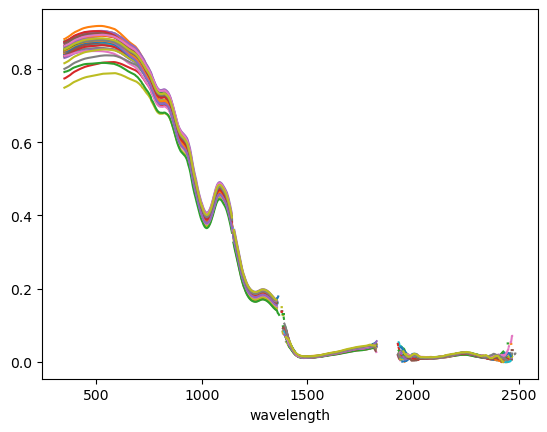

In [36]:
df_a3.plot(legend=False)

<Axes: xlabel='wavelength', ylabel='albedo'>

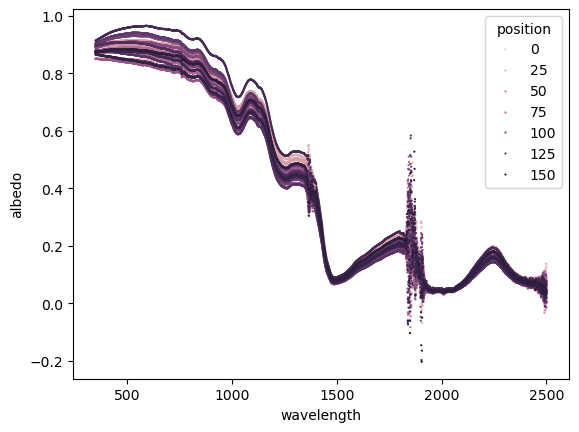

In [74]:
df_temp = df_a2.query('variable in ["albedo", "asd_quality_flag"] ').reset_index()
df_temp = df_temp.pivot(columns='variable', values='value',
    index=['timestamp_akdt', 'site', 'location', 'repetition', 'position', 'wavelength'])
#df_temp = df_temp[df_temp['asd_quality_flag'] == 1.0]
sns.scatterplot(data=df_temp, x='wavelength', y='albedo', hue='position',
               marker='.', edgecolor='none', s=10)

In [19]:
# Plot, write a2 and a3 data, etc...

In [26]:
df_a2

,,,,,,,value
timestamp_akdt,site,location,position,repetition,wavelength,variable,
2024-06-06 14:23:40-08:00,arm,line,0,1.0,350.0,incident_solar_counts,5612.091647
2024-06-06 14:24:01-08:00,arm,line,0,1.0,350.0,reflected_solar_counts,4712.917844
2024-06-06 14:25:15-08:00,arm,line,5,1.0,350.0,incident_solar_counts,5775.384601
2024-06-06 14:25:29-08:00,arm,line,5,1.0,350.0,reflected_solar_counts,5092.166703
2024-06-06 14:26:38-08:00,arm,line,10,1.0,350.0,incident_solar_counts,5670.687747
...,...,...,...,...,...,...,...
2024-06-06 14:53:31-08:00,arm,line,180,1.0,NaN,asd_time_diff_s,-16.000000
2024-06-06 14:54:10-08:00,arm,line,185,1.0,NaN,asd_time_diff_s,-15.000000
2024-06-06 14:54:52-08:00,arm,line,190,1.0,NaN,asd_time_diff_s,-17.000000


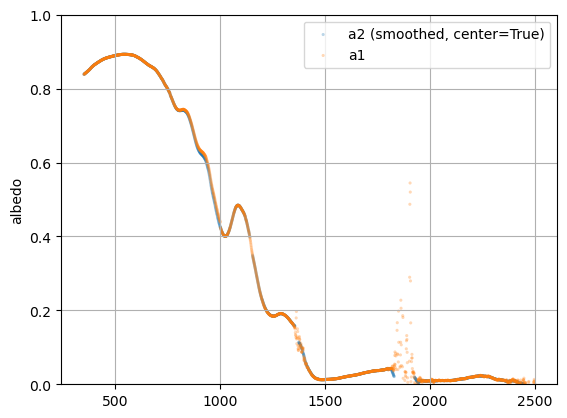

In [20]:
wv_min = 350
wv_max = 2500
pos = 140

df_alb = df_a2.query('variable in ["albedo", "asd_quality_flag"] & position == @pos ' +
                    '& wavelength >= @wv_min & wavelength <= @wv_max').reset_index()
df_alb = df_alb.pivot(columns='variable', values='value',
    index=['timestamp_akdt', 'site', 'location', 'repetition', 'position', 'wavelength'])
# Filter out quality flags == 5
df_alb = df_alb['albedo'].loc[df_alb['asd_quality_flag'] != 5.0].reset_index()
df_alb = df_alb.pivot(index='wavelength', values='albedo',
    columns=['timestamp_akdt', 'site', 'location', 'repetition', 'position'])
df_alb.columns = ['albedo']

df_alb_a1 = df_a1.query('variable in ["albedo"] & position == @pos ' +
                    '& wavelength >= @wv_min & wavelength <= @wv_max').reset_index()
df_alb_a1 = df_alb_a1.pivot(index='wavelength', values='value',
    columns=['timestamp_akdt', 'site', 'location', 'repetition', 'position'])
df_alb_a1.columns = ['albedo']

f, ax = plt.subplots()
ax.scatter('wavelength', 'albedo', s=20, data=df_alb.reset_index(), alpha=0.3, marker='.',
          edgecolor='none')
ax.scatter('wavelength', 'albedo', s=20, data=df_alb_a1.reset_index(), alpha=0.3, marker='.',
          edgecolor='none')
ax.set_ylim([0, 1])
ax.grid()
ax.set_ylabel('albedo')
ax.legend(['a2 (smoothed, center=True)', 'a1'])

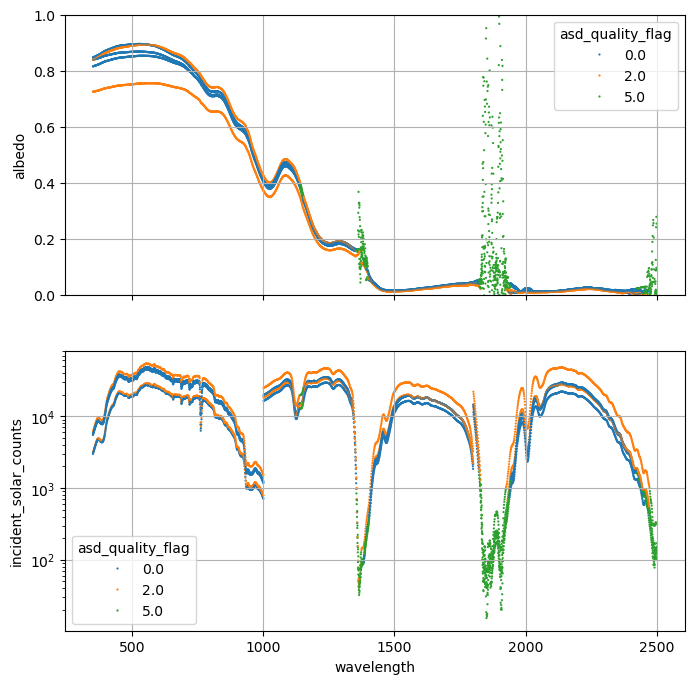

In [21]:
pos = [0, 50, 140, 145, 150]

df_temp = df_a2.query('variable in ["albedo", "incident_solar_counts", "asd_quality_flag"]').reset_index(
    ).drop(columns=['timestamp_akdt', 'site', 'location', 'repetition']).pivot(
    index=['wavelength', 'position'], columns='variable', values='value')
df_temp['asd_quality_flag'] = df_temp['asd_quality_flag'].astype("string")


f, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8))

sns.scatterplot(data=df_temp.query('position in @pos'), x='wavelength', y='albedo', hue='asd_quality_flag',
           marker='.', edgecolor='none', s=10, ax=axs[0])
axs[0].set_ylim([0, 1])
axs[0].grid()

sns.scatterplot(data=df_temp.query('position in @pos'), x='wavelength', y='incident_solar_counts', hue='asd_quality_flag',
           marker='.', edgecolor='none', s=10, ax=axs[1])
#axs[0].set_ylim([0, 1])
axs[1].set_yscale('log')
axs[1].grid()

In [82]:
x = pd.Series(np.arange(10))
print(x)
print(x.rolling(5).mean())

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
dtype: int32
0    NaN
1    NaN
2    NaN
3    NaN
4    2.0
5    3.0
6    4.0
7    5.0
8    6.0
9    7.0
dtype: float64
